Lab Assignment Four: Multi-Layer Perceptron 
In this lab, you will compare the performance of multi-layer perceptrons programmed  via your own various implementations. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. This lab project is slightly different from other reports in that you will be asked to complete more specific items.

Dataset Selection

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0Links to an external site.

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks to an external site. 

The classification task you will be performing is to predict, for each tract, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

Grading Rubric

### Load, Split, and Balance (1.5 points total)
[.5 points] 
- (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. 
- (2) Remove any observations that having missing data. 
- (3) Encode any string data as integers for now. 
- (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data into memory and save it to a pandas data frame
df = pd.read_csv('./acs2017_census_tract_data.csv')

# Remove any observations that have missing data
df.dropna(inplace=True)

# Encode any string data as integers
df = df.apply(lambda x: pd.factorize(x)[0] if x.dtype == 'object' else x)


The next two requirements will need to be completed together as they might depend on one another:
- [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. 

Should balancing of the dataset be done for both the training and testing set? Explain.

No, it should only be done for training. Generally, we don't want to touch the testing set because adjusting the distribution of classes in the testing set could introduce bias and affect the evaluation of the model's generalization performance.


- [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.
Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 

In [2]:
print(df.columns)

Index(['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment'],
      dtype='object')


In [3]:
income_ranges = [0, 50000, 100000, float('inf')]
income_labels = ['<50000', '50000-100000', '>100000']

df['IncomeEncoded'] = pd.cut(df['Income'], bins=income_ranges, labels=income_labels)

df_encoded = pd.get_dummies(df['IncomeEncoded'])
df = pd.concat([df, df_encoded], axis=1)


In [4]:
# X = X.dropna()
# y = y.dropna()

In [5]:
# Iincome' is our target column
X = df.drop('IncomeEncoded', axis=1)  # Features
y = df['IncomeEncoded']  # Target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training set by quantizing the "ChildPoverty" variable into four classes
X_train['ChildPoverty'] = pd.qcut(X_train['ChildPoverty'], q=4, labels=False)


# # One-hot encode the target variable
# y_train_encoded = pd.get_dummies(y_train)
# y_test_encoded = pd.get_dummies(y_test)


# # Normalize the continuous numeric feature data
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [6]:
# Display the first few rows of the dataset
df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,IncomeEncoded,<50000,50000-100000,>100000
0,1001020100,0,0,1845,899,946,2.4,86.3,5.2,0.0,...,881,74.2,21.2,4.5,0.0,4.6,50000-100000,False,True,False
1,1001020200,0,0,2172,1167,1005,1.1,41.6,54.5,0.0,...,852,75.9,15.0,9.0,0.0,3.4,<50000,True,False,False
2,1001020300,0,0,3385,1533,1852,8.0,61.4,26.5,0.6,...,1482,73.3,21.1,4.8,0.7,4.7,<50000,True,False,False
3,1001020400,0,0,4267,2001,2266,9.6,80.3,7.1,0.5,...,1849,75.8,19.7,4.5,0.0,6.1,50000-100000,False,True,False
4,1001020500,0,0,9965,5054,4911,0.9,77.5,16.4,0.0,...,4787,71.4,24.1,4.5,0.0,2.3,50000-100000,False,True,False


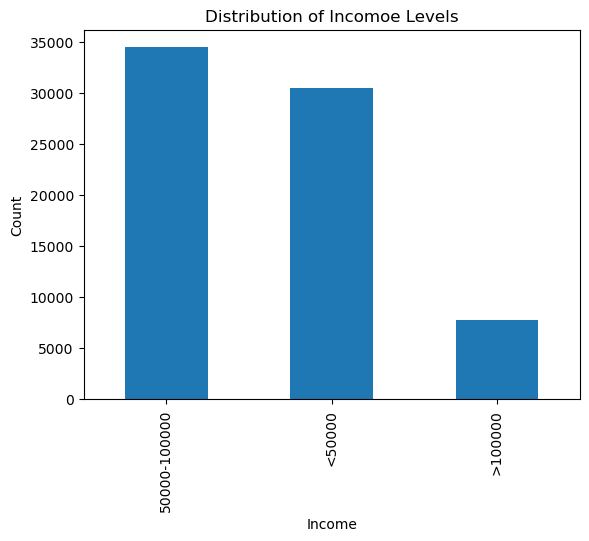

In [7]:
import matplotlib.pyplot as plt

# Create a bar plot of the "Income" variable
df['IncomeEncoded'].value_counts().plot(kind='bar')
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Distribution of Incomoe Levels')
plt.show()


### Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: 
- (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

- [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

- [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

- [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

- [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.



In [8]:
import numpy as np

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(72718, 40)
(72718,)
0 72153750602
['50000-100000' '<50000' '>100000']


In [9]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 40)
(58174,)
(14544, 40)
(14544,)


In [10]:
#Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
#Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    

In [11]:
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [12]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2

In [ ]:
# #this is an error fix using co-pilot. idk if thiss is the right thing to do

# X_train = X_train.astype(float)

# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)


In [20]:
print(type(Z1))
print(Z1.shape)


NameError: name 'Z1' is not defined

In [13]:
%%time

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=50, # iterations
              eta=0.001,  # learning rate
              random_state=1)

nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

TypeError: ufunc 'expit' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [21]:
#this is ai generated code, not from class:

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create a 2-layer perceptron with 10 nodes in the first layer and 5 in the second
mlp = MLPClassifier(hidden_layer_sizes=(10,5), max_iter=1000)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions
predictions = mlp.predict(X_test)


In [22]:
print(confusion_matrix(y_test,predictions))


[[6895    0    0]
 [6104    0    0]
 [1545    0    0]]


In [23]:
print(classification_report(y_test, predictions, zero_division=1))

              precision    recall  f1-score   support

50000-100000       0.47      1.00      0.64      6895
      <50000       1.00      0.00      0.00      6104
     >100000       1.00      0.00      0.00      1545

    accuracy                           0.47     14544
   macro avg       0.82      0.33      0.21     14544
weighted avg       0.75      0.47      0.30     14544




### Modeling (5 points total)
- [1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.

Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

- [1 points] Repeat the previous step, adding support for a fourth layer.

- [1 points] Repeat the previous step, adding support for a fifth layer. 

- [2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.